# ViT Prototype: UNSW-NB15 6-Class Balanced Comparison

**Objective:** Fair comparison with CIC-IoT23 using 6 well-balanced classes from UNSW-NB15.

## Key Configuration
- **Classes:** 6 balanced UNSW classes (excluding Analysis, Backdoor, Shellcode, Worms)
- **Sample limit:** 2500 per class for fair comparison
- **Same architecture:** Identical to CIC experiment

In [1]:
# Section 1: Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration - 6 balanced UNSW classes
CONFIG = {
    'image_size': 32,
    'channels': 5,
    'patch_size': 16,
    'embed_dim': 192,
    'num_heads': 3,
    'num_layers': 6,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 6,
    'max_samples_per_class': 2500
}

# UNSW classes to keep (well-balanced, excluding severely imbalanced ones)
KEEP_CLASSES = ['Normal', 'DoS', 'Exploits', 'Generic', 'Fuzzers', 'Reconnaissance']

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ UNSW-NB15 6-Class Balanced Setup")
print(f"✓ Device: {device}")
print(f"✓ Classes: {KEEP_CLASSES}")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class")
print(f"✓ Excluded (imbalanced): Analysis (48), Backdoor (220), Shellcode (374), Worms (500)")

✓ UNSW-NB15 6-Class Balanced Setup
✓ Device: cpu
✓ Classes: ['Normal', 'DoS', 'Exploits', 'Generic', 'Fuzzers', 'Reconnaissance']
✓ Sample limit: 2500 per class
✓ Excluded (imbalanced): Analysis (48), Backdoor (220), Shellcode (374), Worms (500)


In [2]:
# Load UNSW data - 6 balanced classes only
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/unsw-dataset-samples/parquet/5channel_32x32/'
print(f"Loading UNSW-NB15 6-class balanced dataset from: {data_path}")

def load_unsw_6class_balanced(base_path, keep_classes, max_samples_per_class):
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    print(f"Loading only: {keep_classes}")
    
    for class_name in keep_classes:
        class_dir = f"{base_path}{class_name}/"
        print(f"Loading {class_name} (max {max_samples_per_class} samples)...")
        
        class_samples = 0
        
        for split in splits:
            if class_samples >= max_samples_per_class:
                break
                
            split_path = f"{class_dir}{split}/"
            parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))
            
            for file_path in parquet_files:
                if class_samples >= max_samples_per_class:
                    break
                    
                try:
                    df = pd.read_parquet(file_path)
                    
                    if 'image_data' in df.columns:
                        remaining_samples = max_samples_per_class - class_samples
                        samples_to_take = min(len(df), remaining_samples)
                        
                        for idx in range(samples_to_take):
                            row = df.iloc[idx]
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                            class_samples += 1
                        
                        print(f"   Loaded {samples_to_take} samples from {file_path.split('/')[-1]} (total: {class_samples})")
                except Exception as e:
                    print(f"   Error loading {file_path}: {e}")
    
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n✓ UNSW-NB15 6-class balanced dataset loaded: {len(X)} samples")
    print(f"✓ Classes: {np.unique(y)}")
    
    return X, y

# Load balanced UNSW data
X, y = load_unsw_6class_balanced(data_path, KEEP_CLASSES, CONFIG['max_samples_per_class'])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✓ UNSW-NB15 6-class label distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n✓ Data quality: range=[{X.min():.3f}, {X.max():.3f}], non-zero={np.mean(np.count_nonzero(X, axis=1)):.1f}")
print(f"✓ Fair comparison ready: both datasets now have 6 balanced classes with 2500 samples each")

Loading UNSW-NB15 6-class balanced dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/unsw-dataset-samples/parquet/5channel_32x32/
Loading only: ['Normal', 'DoS', 'Exploits', 'Generic', 'Fuzzers', 'Reconnaissance']
Loading Normal (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00002.parquet (total: 2500)
Loading DoS (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00002.parquet (total: 2500)
Loading Exploits (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00002.parquet (total: 2500)
Loading Generic (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
 

Reshaping UNSW-NB15 data to 5-channel images...
✓ Reshaped to: (15000, 5, 32, 32)

Visualizing UNSW-NB15 sample images for 6 classes (2500 sample limit)...


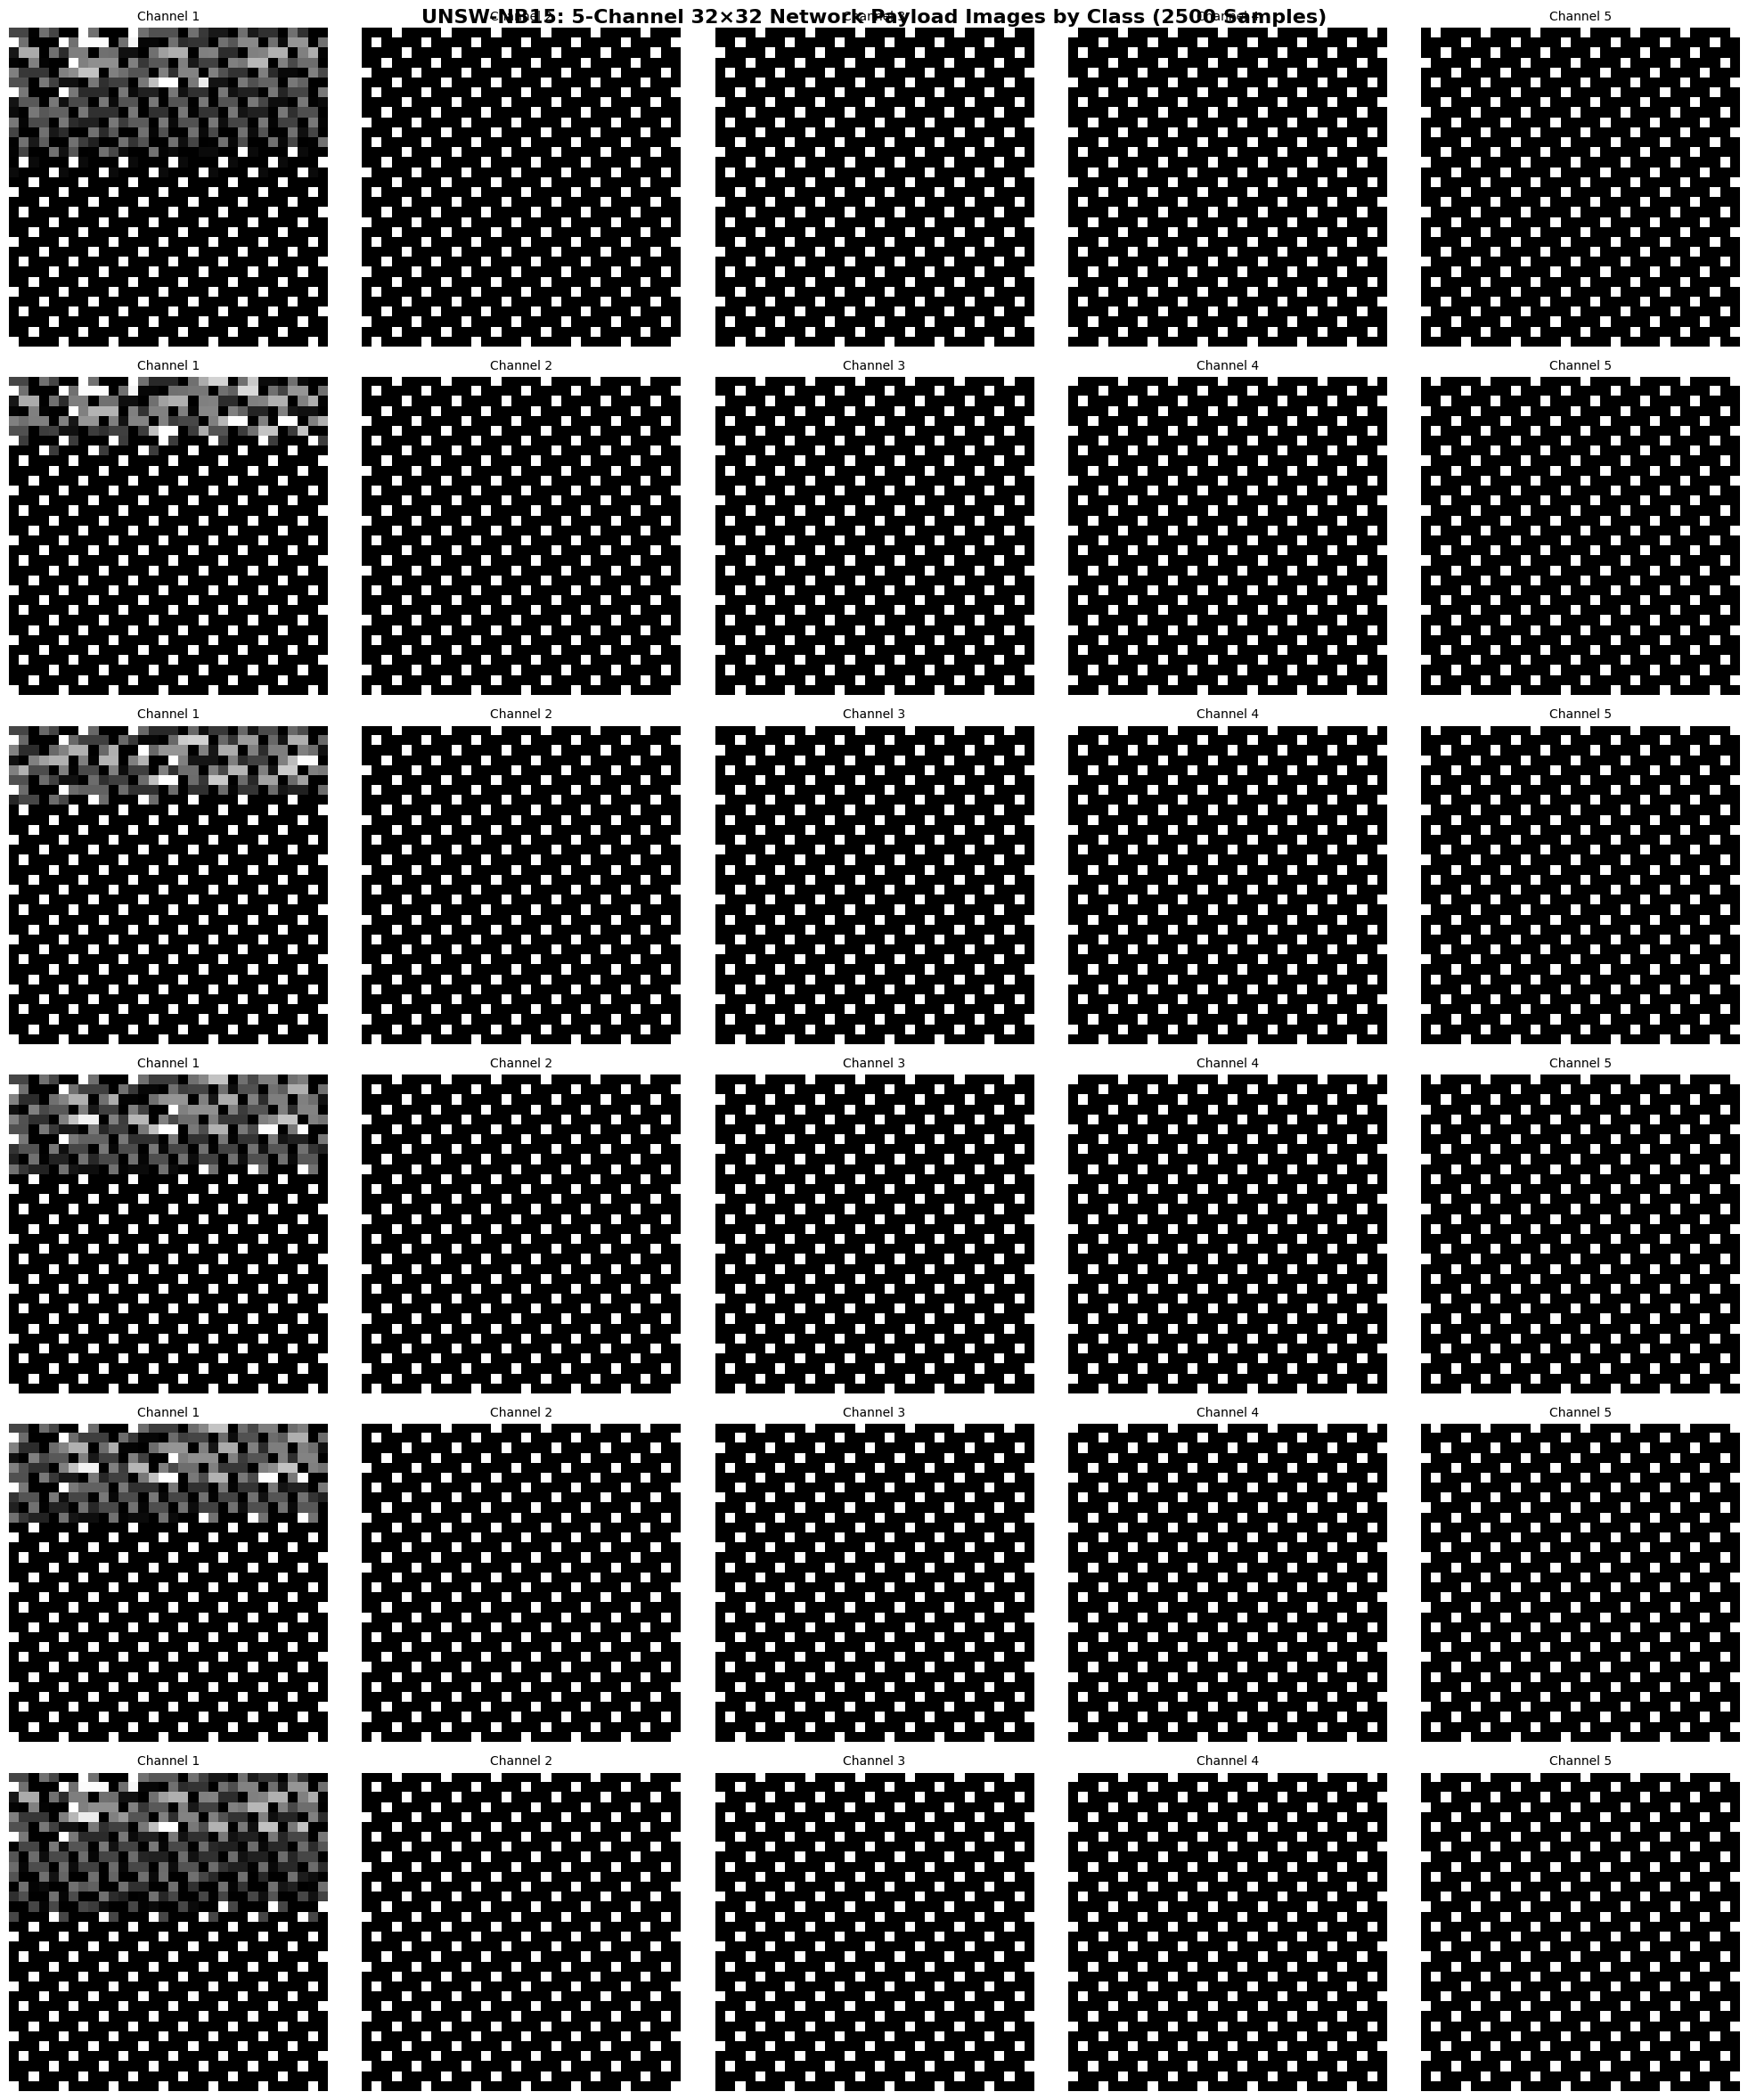


📊 UNSW-NB15 Channel-wise Analysis:
   Channel 1: mean=0.243, std=0.358, nonzero=0.491
   Channel 2: mean=0.215, std=0.385, nonzero=0.286
   Channel 3: mean=0.214, std=0.388, nonzero=0.273
   Channel 4: mean=0.215, std=0.389, nonzero=0.272
   Channel 5: mean=0.214, std=0.389, nonzero=0.268

✓ UNSW-NB15 data visualization and analysis complete!
✓ Ready for ViT model training with 5-channel input
✓ Sample limit enforced: 2500 per class (fair comparison)


In [3]:
# Section 2: Data Reshaping and Visualization
# Reshape data from flat features to 5-channel images
print("Reshaping UNSW-NB15 data to 5-channel images...")

# Expected: (N, 5120) → (N, 5, 32, 32)
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    # Reshape to (N, channels, height, width)
    X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X.shape[1]}, expected {expected_features}")
    # Try to adapt - take first N features if more, or pad if fewer
    if X.shape[1] > expected_features:
        X_trimmed = X[:, :expected_features]
        X_images = X_trimmed.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Trimmed and reshaped to: {X_images.shape}")
    else:
        # Pad with zeros
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_padded = np.concatenate([X, padding], axis=1)
        X_images = X_padded.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Padded and reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample images for each class
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(num_classes, CONFIG['channels'], figsize=(20, 4*num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

print(f"\nVisualizing UNSW-NB15 sample images for {num_classes} classes (2500 sample limit)...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        sample_image = X_images[sample_idx]
        
        # Show each channel
        for channel in range(CONFIG['channels']):
            ax = axes[class_idx, channel] if num_classes > 1 else axes[channel]
            im = ax.imshow(sample_image[channel], cmap='gray', vmin=0, vmax=1)
            if channel == 0:
                ax.set_ylabel(f'{class_name}', fontsize=12)
            ax.set_title(f'Channel {channel+1}', fontsize=10)
            ax.axis('off')

plt.suptitle('UNSW-NB15: 5-Channel 32×32 Network Payload Images by Class (2500 Samples)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics
print(f"\n📊 UNSW-NB15 Channel-wise Analysis:")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   Channel {channel+1}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

print(f"\n✓ UNSW-NB15 data visualization and analysis complete!")
print(f"✓ Ready for ViT model training with {CONFIG['channels']}-channel input")
print(f"✓ Sample limit enforced: {CONFIG['max_samples_per_class']} per class (fair comparison)")

In [4]:
# Section 3: Multi-Channel Vision Transformer Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the Multi-Channel Vision Transformer for UNSW-NB15
model = MultiChannelVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 UNSW-NB15 Multi-Channel Vision Transformer Model (2500 Sample Limit):")
print(f"✓ Input: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class (fair comparison)")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ UNSW-NB15 multi-channel ViT architecture ready!")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {KEEP_CLASSES}")
print(f"✓ Ready for controlled comparison with CIC-IoT23 dataset")

🤖 UNSW-NB15 Multi-Channel Vision Transformer Model (2500 Sample Limit):
✓ Input: 5-channel 32×32 images
✓ Patches per image: 4
✓ Total parameters: 2,917,830
✓ Trainable parameters: 2,917,830
✓ Model size: 11.1 MB
✓ Sample limit: 2500 per class (fair comparison)
✓ Forward pass test: torch.Size([2, 5, 32, 32]) → torch.Size([2, 6])

✓ UNSW-NB15 multi-channel ViT architecture ready!
✓ Configured for 6 classes: ['Normal', 'DoS', 'Exploits', 'Generic', 'Fuzzers', 'Reconnaissance']
✓ Ready for controlled comparison with CIC-IoT23 dataset


Preparing UNSW-NB15 training pipeline for 2500-sample comparison...
✓ Tensor conversion: X=torch.Size([15000, 5, 32, 32]), y=torch.Size([15000])
✓ UNSW-NB15 data splits (from 2500 per class):
   Train: 10500 samples
   Val:   2250 samples
   Test:  2250 samples
✓ Class weights: [1. 1. 1. 1. 1. 1.]
✓ Data loaders: 329 train, 71 val, 71 test batches
✓ UNSW-NB15 training setup complete

🚀 Starting UNSW-NB15 6-Class ViT training for 30 epochs...
✓ Fair comparison mode: 2500 samples per class (same as CIC)
Epoch  1/30: Train Loss: 1.7958, Train Acc: 19.11% | Val Loss: 1.8802, Val Acc: 17.64%
Epoch  2/30: Train Loss: 1.7268, Train Acc: 23.12% | Val Loss: 1.7047, Val Acc: 22.13%
Epoch  3/30: Train Loss: 1.7070, Train Acc: 24.87% | Val Loss: 1.7102, Val Acc: 24.40%
Epoch  4/30: Train Loss: 1.6918, Train Acc: 25.35% | Val Loss: 1.6920, Val Acc: 25.87%
Epoch  5/30: Train Loss: 1.6718, Train Acc: 26.64% | Val Loss: 1.6515, Val Acc: 27.56%
Epoch  6/30: Train Loss: 1.6487, Train Acc: 27.55% | Val L

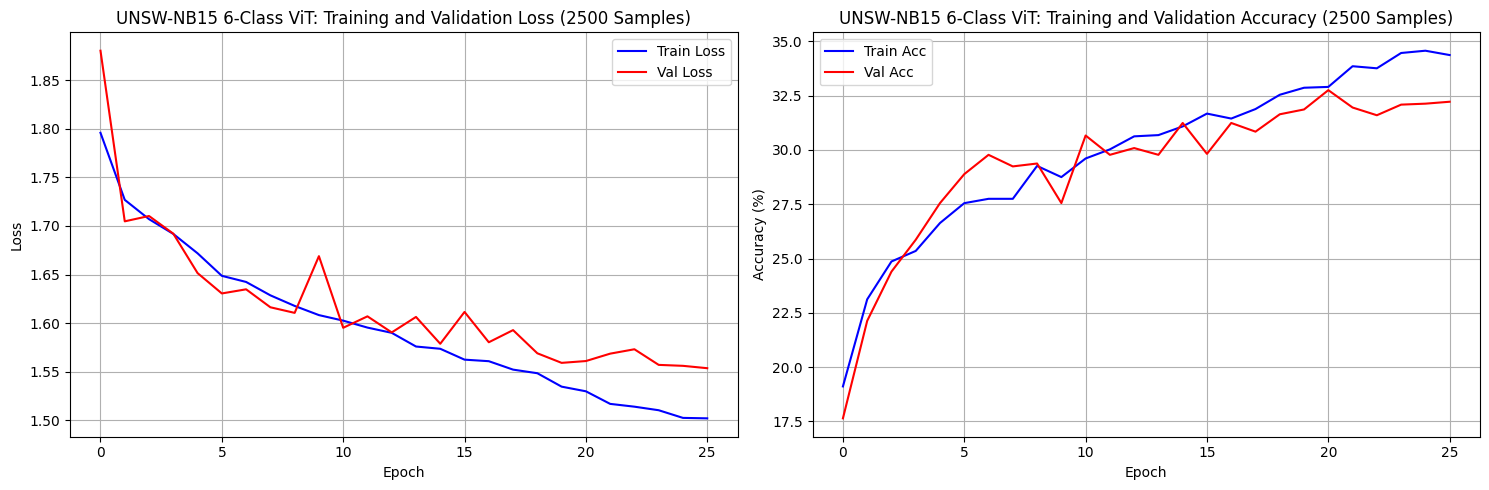


✓ UNSW-NB15 6-Class ViT training complete!
✓ Ready for evaluation and comparison with CIC-IoT23 dataset


In [5]:
# Section 4: Training Pipeline
print("Preparing UNSW-NB15 training pipeline for 2500-sample comparison...")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")

# Stratified train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ UNSW-NB15 data splits (from {CONFIG['max_samples_per_class']} per class):")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ UNSW-NB15 training setup complete")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting UNSW-NB15 6-Class ViT training for {CONFIG['epochs']} epochs...")
print(f"✓ Fair comparison mode: {CONFIG['max_samples_per_class']} samples per class (same as CIC)")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_unsw_6class_vit_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ UNSW-NB15 training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('UNSW-NB15 6-Class ViT: Training and Validation Loss (2500 Samples)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('UNSW-NB15 6-Class ViT: Training and Validation Accuracy (2500 Samples)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ UNSW-NB15 6-Class ViT training complete!")
print(f"✓ Ready for evaluation and comparison with CIC-IoT23 dataset")

🔍 UNSW-NB15 6-Class ViT Evaluation on Test Set (2500 Sample Comparison)
🎯 UNSW-NB15 6-Class ViT Test Results (2500 Sample Comparison):
✓ Test Accuracy: 32.09%
✓ Test Loss: 1.5348
✓ Samples evaluated: 2,250
✓ Sample limit enforced: 2500 per class (same as CIC)

📊 UNSW-NB15 Per-Class Performance:
--------------------------------------------------------------------------------

📈 UNSW-NB15 Overall Metrics:
✓ Macro Avg: Precision=0.314, Recall=0.321, F1=0.290
✓ Weighted Avg: Precision=0.314, Recall=0.321, F1=0.290


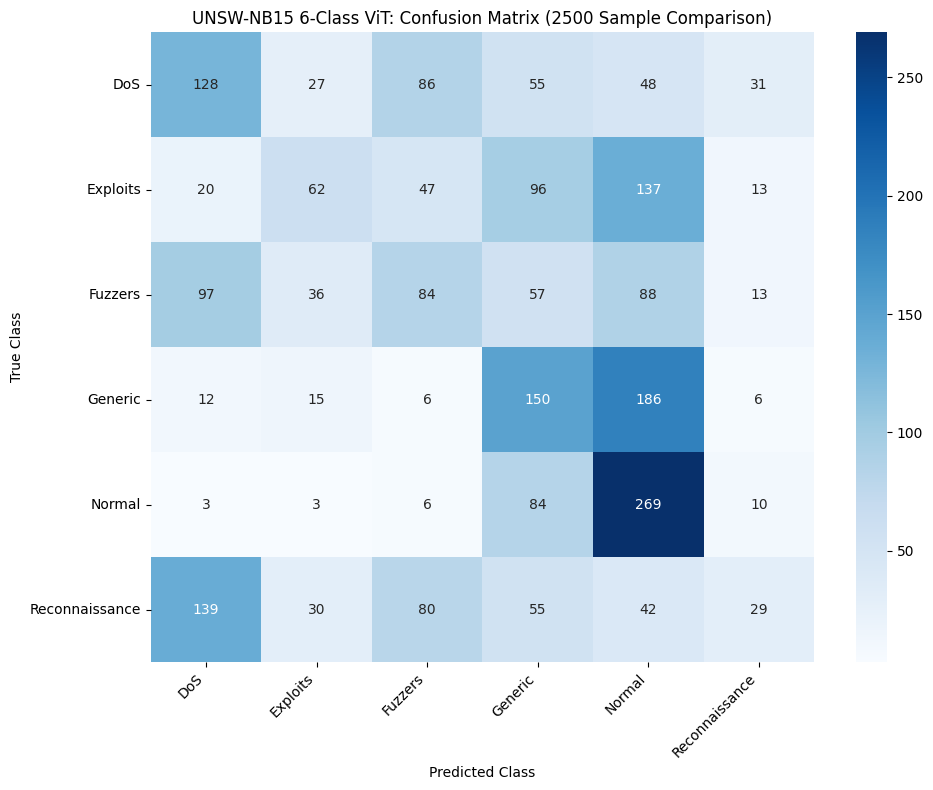


📊 UNSW-NB15 Class-wise Accuracy:
   DoS                 :  34.1% (375 samples)
   Exploits            :  16.5% (375 samples)
   Fuzzers             :  22.4% (375 samples)
   Generic             :  40.0% (375 samples)
   Normal              :  71.7% (375 samples)
   Reconnaissance      :   7.7% (375 samples)

💡 UNSW-NB15 6-Class ViT Key Results (2500 Sample Comparison):
✓ Overall test accuracy: 32.09%
✓ Number of classes: 6
✓ Model complexity: 2,917,830 parameters
✓ Input format: 5-channel 32×32 images
✓ Sample limit: 2500 per class (same as CIC)
✓ Total samples: 15,000 (2,500 per class)

✓ UNSW-NB15 results saved to results_unsw_6class_32x32_balanced.json
✓ UNSW-NB15 6-Class ViT evaluation complete!
✓ Ready for direct comparison with CIC-IoT23 dataset results

🔬 Fair Comparison Enabled:
   • CIC-IoT23 Dataset: 2500 samples per class
   • UNSW-NB15 Dataset: 2500 samples per class
   • Same model architecture and training procedure
   • Direct performance comparison now possible!


In [6]:
# Section 5: Evaluation & Results Analysis
print("🔍 UNSW-NB15 6-Class ViT Evaluation on Test Set (2500 Sample Comparison)")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_unsw_6class_vit_model.pth'))
model.eval()

# Comprehensive evaluation
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# Run evaluation
test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 UNSW-NB15 6-Class ViT Test Results (2500 Sample Comparison):")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")
print(f"✓ Sample limit enforced: {CONFIG['max_samples_per_class']} per class (same as CIC)")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 UNSW-NB15 Per-Class Performance:")
print("-" * 80)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:20s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 UNSW-NB15 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('UNSW-NB15 6-Class ViT: Confusion Matrix (2500 Sample Comparison)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
print(f"\n📊 UNSW-NB15 Class-wise Accuracy:")
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(predictions[class_mask] == targets[class_mask]) * 100
        sample_count = np.sum(class_mask)
        class_accuracies.append((class_name, class_acc, sample_count))
        print(f"   {class_name:20s}: {class_acc:5.1f}% ({sample_count:,} samples)")

# Performance summary
print(f"\n💡 UNSW-NB15 6-Class ViT Key Results (2500 Sample Comparison):")
print(f"✓ Overall test accuracy: {test_accuracy:.2f}%")
print(f"✓ Number of classes: {CONFIG['num_classes']}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class (same as CIC)")
print(f"✓ Total samples: {len(y):,} ({len(y)//CONFIG['num_classes']:,} per class)")

# Save results for comparison
results_unsw_6class_balanced = {
    'model_type': 'unsw_6class_32x32_balanced',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'sample_limit': CONFIG['max_samples_per_class'],
    'total_samples': len(y),
    'class_accuracies': class_accuracies,
    'confusion_matrix': cm.tolist(),
    'classification_report': report,
    'classes': KEEP_CLASSES
}

import json
with open('results_unsw_6class_32x32_balanced.json', 'w') as f:
    json.dump(results_unsw_6class_balanced, f, indent=2, default=str)

print(f"\n✓ UNSW-NB15 results saved to results_unsw_6class_32x32_balanced.json")
print(f"✓ UNSW-NB15 6-Class ViT evaluation complete!")
print(f"✓ Ready for direct comparison with CIC-IoT23 dataset results")
print(f"\n🔬 Fair Comparison Enabled:")
print(f"   • CIC-IoT23 Dataset: {CONFIG['max_samples_per_class']} samples per class")
print(f"   • UNSW-NB15 Dataset: {CONFIG['max_samples_per_class']} samples per class")
print(f"   • Same model architecture and training procedure")
print(f"   • Direct performance comparison now possible!")